<div class="alert alert-block alert-success">
    <b><center>CONVOLUTON NEURAL NETWORK</center></b>
    <b><center>MNIST 데이터로 DNN 구현해 보기</center></b>
</div>

# Configure Learning Environment

In [1]:
# !pip install git+https://github.com/nockchun/rspy --force
import rspy as rsp
rsp.setSystemWarning(off=True)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import sklearn.preprocessing as skpreproc
from ipywidgets import interact
import tensorflow as tf
from tensorflow.keras import utils, layers, models, losses, preprocessing

In [3]:
np.set_printoptions(linewidth=200, precision=2)
tf.__version__

'2.4.1'

# Data Loading

* UCI Machine Learning Repository 데이터 이용
* https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset#

In [4]:
originData = pd.read_csv("resources/bike_share_day.csv")

In [5]:
originData.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [6]:
originData.shape

(731, 16)

# Data Exploration & Analysis

## 데이터 내용
>* instant : 기록 순서
>* dteday : 기록 날짜
>* season : 계절 [1:봄, 2:여름, 3:가을, 4:겨울]
>* yr : 년
>* mnth : 월 [1-12]
>* holiday : 국경일 유무 [0:무, 1:유]
>* weekday : 요일 [0:일, 1:월, 2:화, 3:수, 4:목, 5:금, 6:토]
>* workingday : 휴무일 유무 [0:일하는 날, 1:쉬는 날]
>* weathersit
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
>* temp : 정규화된 섭씨 온도(℃)
>* atemp : 정규화된 체감 온도. (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50
>* hum : 정규화된 습도.
>* windspeed : 정규화된 풍속.
>* casual : 일반 사용자.
>* registered : 예약 사용자.
>* cnt : 일반 + 예약 사용자. (전체 사용자)

In [7]:
cols = ["season", "mnth", "holiday", "weekday", "workingday", "weathersit", "atemp", "hum", "windspeed"]
@interact(compare=cols)
def exploration(compare):
    fig, ax1 = plt.subplots(figsize=(30, 8))
    ax2 = ax1.twinx()
    
    ax1.plot(originData.cnt.values, color="#3186ad", label="cnt")
    ax1.plot(originData.casual.values, color="#bebebe", label="casual")
    ax1.plot(originData.registered.values, color="#878787", label="registered")
    ax1.set_ylabel("cnt")

    ax2.plot(originData[compare].values, color="red", alpha=0.7, label="compare")
    ax2.set_ylabel(compare)
    
    ax1.legend(title="Species", loc="upper left")
    plt.show()

interactive(children=(Dropdown(description='compare', options=('season', 'mnth', 'holiday', 'weekday', 'workin…

# Preprocessing Data

## one-hot encoding

In [8]:
onehotWeekday = pd.get_dummies(originData["weekday"], prefix="weekday")
onehotWeathersit = pd.get_dummies(originData["weathersit"], prefix="weathersit")
onehotMnth = pd.get_dummies(originData["mnth"], prefix="mnth")

In [9]:
data = originData.join(onehotWeekday).join(onehotWeathersit).join(onehotMnth)

In [10]:
print(list(data.columns))

['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_1', 'weathersit_2', 'weathersit_3', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12']


## Scaling Y

In [11]:
scaler = skpreproc.MinMaxScaler((0, 1))
scaled = scaler.fit_transform( data["cnt"].values.reshape(len(data["cnt"]), 1) )
scaledSeries = pd.DataFrame(scaled)
scaledSeries.columns = ["cntscl"]

In [12]:
data = pd.merge(data, scaledSeries, left_index=True, right_index=True)
data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,cntscl
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0,0,0,0,0,0,0,0,0,0.110792
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,0,0,0,0,0,0,0,0,0.089623
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0,0,0,0,0,0,0,0,0,0.152669
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0,0,0,0,0,0,0,0,0,0.177174
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0,0,0,0,0,0,0,0,0,0.181546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,...,0,0,0,0,0,0,0,0,1,0.240681
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,...,0,0,0,0,0,0,0,0,1,0.353543
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,...,0,0,0,0,0,0,0,0,1,0.151749
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,...,0,0,0,0,0,0,0,0,1,0.204096


## Splitting

In [13]:
SIZE_DATA_TEST   = 50
SIZE_DATA_HOLDOUT = 50
SIZE_DATA_TRAIN   = len(data) - SIZE_DATA_TEST - SIZE_DATA_HOLDOUT
f"SPLIT [total:{len(data)}, train:{SIZE_DATA_TRAIN}, test:{SIZE_DATA_TEST}, holdout:{SIZE_DATA_HOLDOUT}]"

'SPLIT [total:731, train:631, test:50, holdout:50]'

In [14]:
dataTrain = data[:SIZE_DATA_TRAIN]
dataTest = data[-(SIZE_DATA_TEST+SIZE_DATA_HOLDOUT):-SIZE_DATA_HOLDOUT]
dataHold = data[-SIZE_DATA_HOLDOUT:]

# Prepare Data

In [15]:
dataTrainFeed = np.array(dataTrain[
    ["holiday", "workingday", "temp", "atemp", "hum", "windspeed",
     "weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6",
     "weathersit_1", "weathersit_2", "weathersit_3", "cntscl"]])
outSeqTrain = np.array(dataTrain["cntscl"]).reshape((-1, 1))
dataTrainFeed.shape, outSeqTrain.shape

((631, 17), (631, 1))

In [16]:
dataTestFeed = np.array(dataTest[
    ["holiday", "workingday", "temp", "atemp", "hum", "windspeed",
     "weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6",
     "weathersit_1", "weathersit_2", "weathersit_3", "cntscl"]])
outSeqTest = np.array(dataTest["cntscl"]).reshape((-1, 1))
dataTestFeed.shape, outSeqTest.shape

((50, 17), (50, 1))

In [17]:
dataHoldFeed = np.array(dataHold[
    ["holiday", "workingday", "temp", "atemp", "hum", "windspeed",
     "weekday_0", "weekday_1", "weekday_2", "weekday_3", "weekday_4", "weekday_5", "weekday_6",
     "weathersit_1", "weathersit_2", "weathersit_3", "cntscl"]])
outSeqHold = np.array(dataHold["cntscl"]).reshape((-1, 1))
dataHoldFeed.shape, outSeqHold.shape

((50, 17), (50, 1))

In [18]:
SIZE_FEATURES = dataTrainFeed.shape[1]
SIZE_INPUT = 5
generatorTrain = preprocessing.sequence.TimeseriesGenerator(dataTrainFeed, outSeqTrain, length=SIZE_INPUT, batch_size=SIZE_DATA_TRAIN)

In [19]:
generatorTest = preprocessing.sequence.TimeseriesGenerator(dataTestFeed, outSeqTest, length=SIZE_INPUT, batch_size=1)

In [20]:
generatorHold = preprocessing.sequence.TimeseriesGenerator(dataHoldFeed, outSeqHold, length=SIZE_INPUT, batch_size=1)

In [21]:
for i in range(SIZE_DATA_HOLDOUT):
    x, y = generatorHold[i]
    print('%s => %s' % (x, y))

[[[1.   0.   0.48 0.48 0.74 0.17 0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.72]
  [0.   1.   0.34 0.32 0.66 0.34 0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.47]
  [0.   1.   0.29 0.28 0.55 0.2  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.63]
  [0.   1.   0.32 0.32 0.62 0.15 0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.62]
  [0.   1.   0.34 0.35 0.52 0.17 0.   0.   0.   0.   0.   1.   0.   1.   0.   0.   0.65]]] => [[0.65]]
[[[0.   1.   0.34 0.32 0.66 0.34 0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.47]
  [0.   1.   0.29 0.28 0.55 0.2  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.63]
  [0.   1.   0.32 0.32 0.62 0.15 0.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.62]
  [0.   1.   0.34 0.35 0.52 0.17 0.   0.   0.   0.   0.   1.   0.   1.   0.   0.   0.65]
  [0.   0.   0.33 0.33 0.55 0.18 0.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.65]]] => [[0.53]]
[[[0.   1.   0.29 0.28 0.55 0.2  0.   0.   0.   1.   0.   0.   0.   1.   0.   0.  

# Generate Model

In [22]:
model = models.Sequential([
    layers.Input([SIZE_INPUT, SIZE_FEATURES]),
    layers.SimpleRNN(20, return_sequences=True),
    layers.TimeDistributed(layers.Dropout(.2)),
    layers.SimpleRNN(20),
    layers.Dropout(.2),
    layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5, 20)             760       
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 20)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"]
)

# Training

In [24]:
history = model.fit_generator(
    generatorTrain,
    epochs=100,
    verbose=0,
    validation_data=generatorTest
)

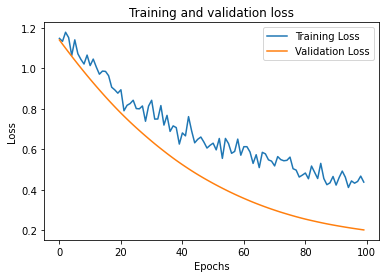

In [25]:
loss = history.history["loss"]
validationLoss = history.history["val_loss"]
epochs = range(0, len(loss))

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, validationLoss, label="Validation Loss")
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict

In [26]:
df_result = pd.DataFrame({'Actual' : [], 'Prediction' : []})

for i in range(len(generatorHold)):
    x, y = generatorHold[i]
    x_input = np.array(x).reshape((1, SIZE_INPUT, SIZE_FEATURES))
    yhat = model.predict(x_input)
    df_result = df_result.append({'Actual': scaler.inverse_transform(y)[0][0], 'Prediction': scaler.inverse_transform(yhat)[0][0]}, ignore_index=True)

In [27]:
df_result['Diff'] = 100 * (df_result['Prediction'] - df_result['Actual']) / df_result['Actual']
df_result.head()

,Actual,Prediction,Diff
0,5629.0,-1309.565674,-123.264624
1,4669.0,6961.285156,49.095848
2,5499.0,2115.433350,-61.530581
3,5634.0,6696.177246,18.852986
4,5146.0,6280.199707,22.040414


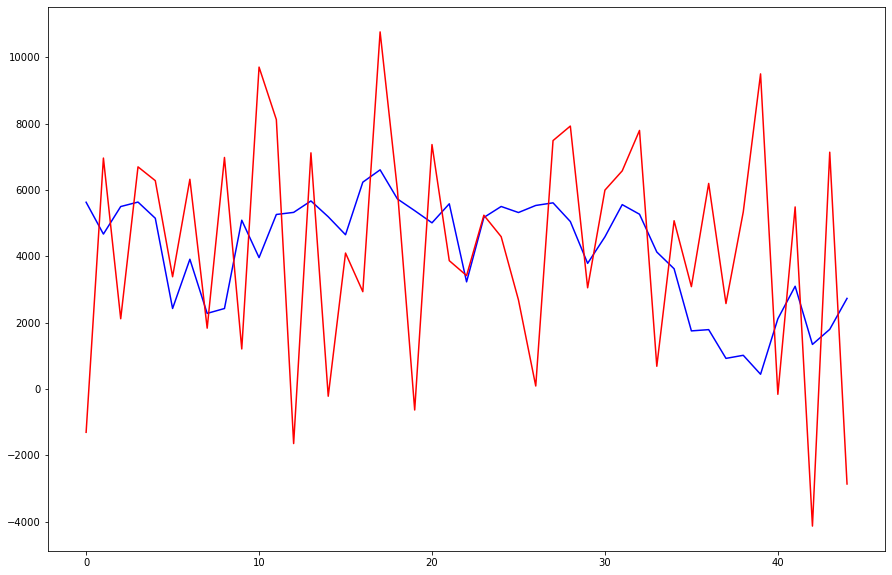

In [28]:
plt.figure(figsize=(15,10))
plt.plot(df_result['Actual'], color='blue')
plt.plot(df_result['Prediction'], color='red')
plt.show()